In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import sklearn.preprocessing

This data is CGM values in mg/dl and is in 15 minute increments. Each row is a new patient (97 patients) and each column is a reading. Each patient has 480 readings or 5 days of data 

In [21]:
device = "cuda"

In [22]:
df = pd.read_csv("cgm_data.csv").sample(frac=1) #shuffle data rows (patients)
for column in df.columns:
    df[column] = df[column].astype(float) #convert columns into floats
ptids = df["ptid"]
df = df.drop("ptid",axis=1)

In [466]:
class LSTMPredictor2(torch.nn.Module):
    def __init__(self, num_layers = 2,n_hidden=51, dropout=0, device='cpu', batch_first=True):
        super(LSTMPredictor2, self).__init__()
        self.n_hidden = n_hidden
        self.num_layers = num_layers
        self.device = device
        self.droupout = dropout
        # lstm1, linear
        
        self.lstm = torch.nn.LSTM(input_size = 1,
                                  hidden_size = self.n_hidden, 
                                  num_layers=self.num_layers, 
                                  dropout = self.droupout, 
                                  device=self.device,
                                  batch_first=True)
        
        self.linear = torch.nn.Linear(self.n_hidden,
                                      1, 
                                      device=self.device)
        self.relu = torch.nn.ReLU()
        
    def forward(self,x,future=0):
        # N, 100
        x = x.to(self.device)
        n_samples = x.size(0)
        h_t = torch.zeros(self.num_layers, x.shape[0],self.n_hidden, dtype = torch.float32, device=self.device)
        c_t = torch.zeros(self.num_layers, x.shape[0],self.n_hidden, dtype = torch.float32, device=self.device)
        
        #N, 1
        input_t = x
        #print(input_t)
        #print(input_t.shape)
        #print(h_t.shape)
        #print(c_t.shape,"\n")
        output, hidden = self.lstm(input_t, (h_t,c_t))
        h_t,c_t = hidden
        #h_t = h_t.view(self.num_layers,-1, self.n_hidden)
        #final_h_t = self.relu(h_t)

        output = self.linear(output)
        return output

In [467]:
train_input = torch.from_numpy(df.iloc[1:90,:-1].values).float().to(device)
train_target = torch.from_numpy(df.iloc[1:90,1:].values).float().to(device)
test_input = torch.from_numpy(df.iloc[90:,:-1].values).float().to(device)
test_target = torch.from_numpy(df.iloc[90:,1:].values).float().to(device)

train_input = torch.unsqueeze(train_input,-1)
train_target = torch.unsqueeze(train_target,-1)
test_input = torch.unsqueeze(test_input,-1)
test_target = torch.unsqueeze(test_target,-1)


In [468]:
model = LSTMPredictor2(n_hidden=51,num_layers=2,device='cuda')
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 3000

In [469]:
losses = []
test_losses = []
for i in tqdm(range(epochs)):
    model.zero_grad()
    out = model(train_input)
    loss = criterion(out,train_target)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        future= 0
        pred = model(test_input, future = 0)
        loss = criterion(pred, test_target)
        test_losses.append(loss.item())
        #y = pred.detach().numpy()
    

100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:24<00:00, 121.23it/s]


In [463]:
torch.save(model, "LSTM")

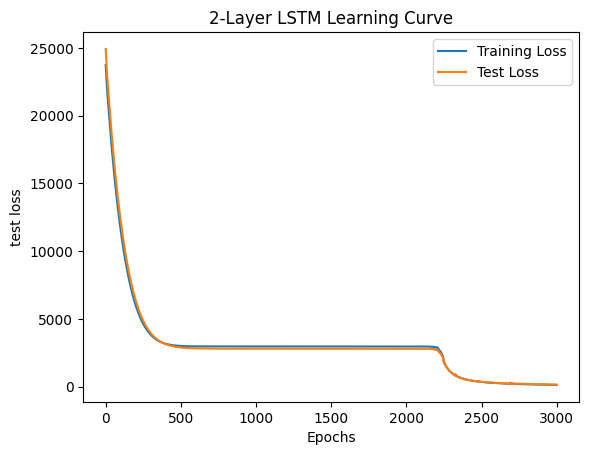

146.67440795898438


In [470]:
#Training Curve
plt.figure()
plt.plot(range(epochs), losses, label = "Training Loss")
plt.plot(range(epochs), test_losses, label = "Test Loss")
plt.ylabel("test loss")
plt.xlabel("Epochs")
plt.title("2-Layer LSTM Learning Curve")
plt.legend()
plt.show()
print(test_losses[-1])

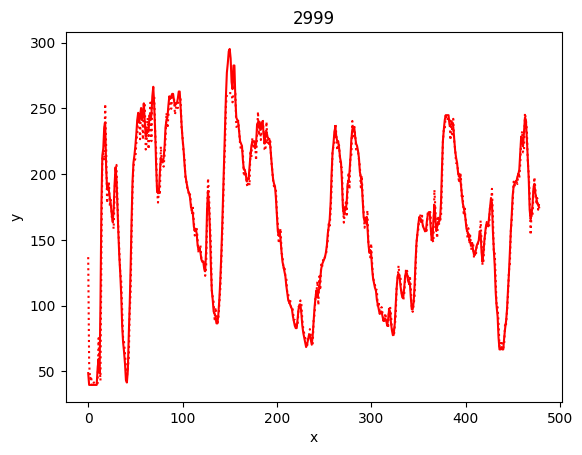

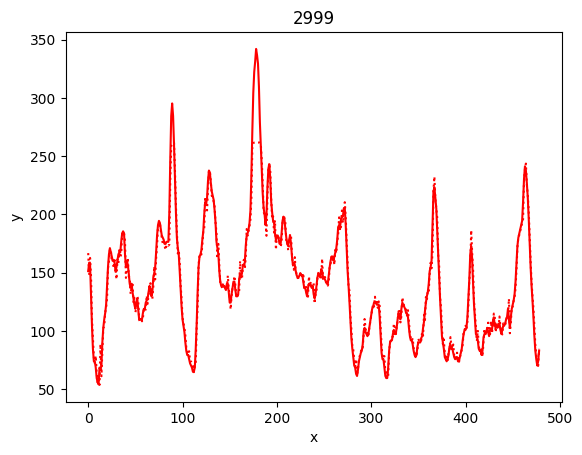

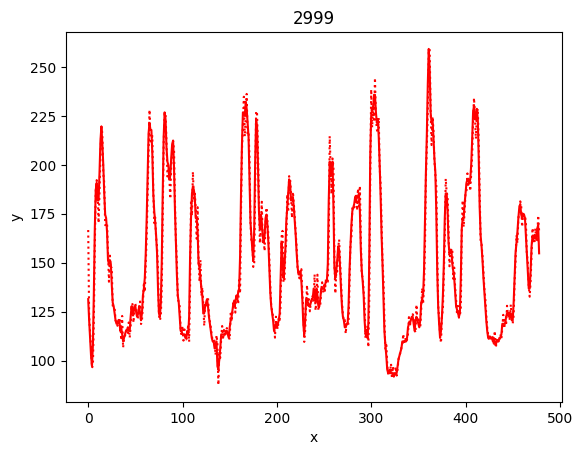

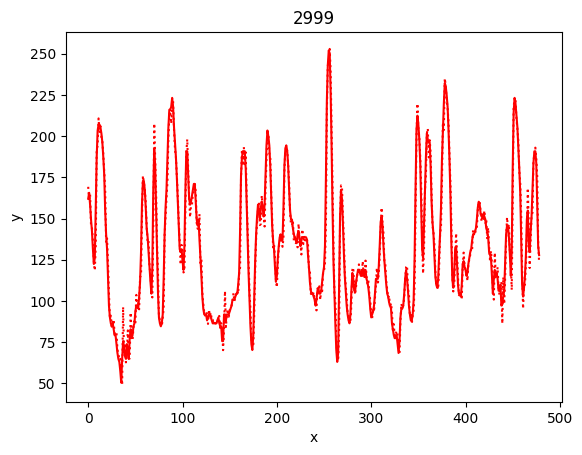

In [472]:
def draw(true, pred, index,future, color):
    true = true.to('cpu')
    pred = pred.to("cpu")
    plt.figure()
    plt.title(i)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xticks()
    plt.yticks()
    n = train_input.shape[1]
    plt.plot(np.arange(n), true[index,:], color)
    plt.plot(np.arange(n+future), pred[index,:], color + ":")
    plt.show()

    
draw(test_target, pred,0,0,'r')
draw(test_target, pred,1,0,'r')
draw(test_target, pred,2,0,'r')
draw(test_target, pred,3,0,'r')



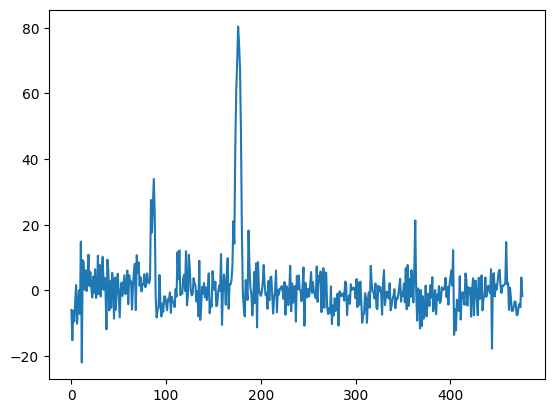

In [478]:
plt.figure()
plt.plot(range(len(test_target[1,2:])),test_target[1,2:].to('cpu') - pred[1,2:].to('cpu'))
plt.show()

### Single Layer

In [165]:
device = 'cuda'
train_size = 90 
lookback_size = 96
epochs = 500
learning_rate = 0.001
hidden_size = 1024

In [166]:
#create model
class SimpleLinear(torch.nn.Module):
    def __init__(self,input_size, hidden_size, device='cpu'):
        super(SimpleLinear, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.device = device
        self.linear1 = torch.nn.Linear(self.input_size, 1, device=self.device).double()
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(self.hidden_size, 1, device=self.device).double()
    
    def forward(self,x):
        x = self.linear1(x)
        #x = self.relu(x)
        #x = self.linear2(x)
        return x

In [167]:
#prepare data

df = pd.read_csv("cgm_data.csv").sample(frac=1) #shuffle data rows (patients)
for column in df.columns:
    df[column] = df[column].astype(float) #convert columns into floats
ptids = df["ptid"]
df = df.drop("ptid",axis=1)

train_df = df.iloc[1:train_size,:]
test_df =  df.iloc[train_size:,:]

mean = train_df.mean(axis=None)
std = train_df.values.std(axis=None)

train_x = []
train_y = []
test_x = []
test_y = []
for i in range(len(df.columns)-lookback_size):
    train_x.append(((train_df.iloc[:,i:i+lookback_size].values - mean)/std))
    train_y.append(train_df.iloc[:,i+lookback_size].values)
    test_x.append(((test_df.iloc[:,i:i+lookback_size].values - mean)/std))
    test_y.append(test_df.iloc[:,i+lookback_size].values)

train_x = torch.from_numpy(np.array(train_x)).to(device) # [batch,patient id,sequence]
train_y = torch.from_numpy(np.array(train_y)).to(device) # [batch,patient id]
test_x = torch.from_numpy(np.array(test_x)).to(device)
test_y = torch.from_numpy(np.array(test_y)).to(device)

In [168]:
#instantiate model
model = SimpleLinear(input_size=lookback_size,hidden_size = hidden_size,device=device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [169]:
#train and test model
losses = []
test_losses = []
for i in tqdm(range(epochs)):
    
    for j in range(0,train_x.shape[0]):
        batch_x = train_x[j,:,:]
        batch_y = train_y[j,:]
        
        model.zero_grad()
        out = model(batch_x)
        loss = criterion(out,batch_y)
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    
    with torch.no_grad():
        pred = model(torch.reshape(test_x, [-1,lookback_size]))
        loss = criterion(pred, torch.reshape(test_y,[-1]))
        test_losses.append(loss.item())
        

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]C:\Users\Hamza\anaconda\envs\ass4\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([89])) that is different to the input size (torch.Size([89, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Hamza\anaconda\envs\ass4\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2688])) that is different to the input size (torch.Size([2688, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:53<00:00,  4.40it/s]


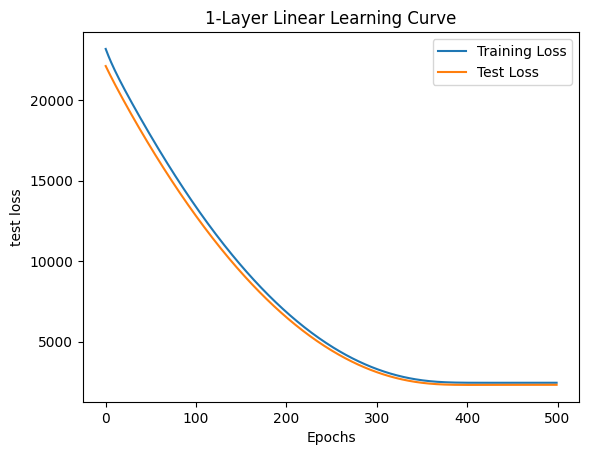

In [170]:
#Training Curve
plt.figure()
plt.plot(range(len(losses)), losses, label = "Training Loss")
plt.plot(range(len(test_losses)), test_losses, label = "Test Loss")
plt.ylabel("test loss")
plt.xlabel("Epochs")
plt.title("1-Layer Linear Learning Curve")
plt.legend()
plt.show()

In [171]:
predicted = np.reshape(pred.to("cpu"),[480-lookback_size,7])

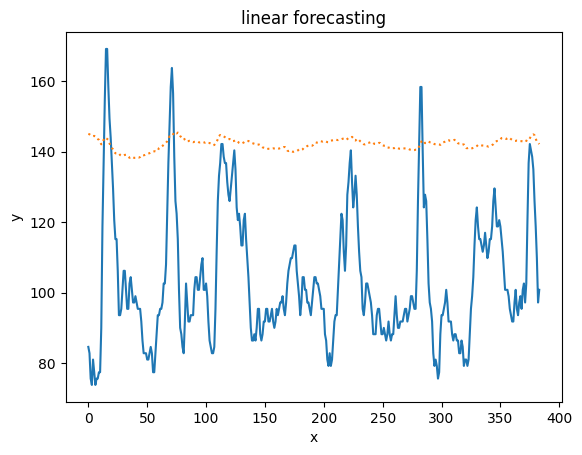

In [172]:
plt.figure()
plt.title("linear forecasting")
plt.xlabel("x")
plt.ylabel("y")
plt.xticks()
plt.yticks()
plt.plot(np.arange(test_y.shape[0]), test_y.to("cpu")[:,1])
plt.plot(np.arange(test_y.shape[0]), predicted[:,1], ":")
plt.show()